# <a id='toc1_'></a>[Classifying thyroid cancer from numerical data](#toc0_)

## <a id='toc1_1_'></a>[Abstract](#toc0_)

This notebook demonstrates a simple machine learning pipeline used to diagnose Thyroid cancer from numerical data. The dataset was sourced from kaggle, and we apply a binary classifier neural network to the dataset to predict whether a diagnosis was benign or malignant. We see the produced model is prone to predicting false negatives which could be a major concern in a medical setting, and so further work is needed to refine this.

## <a id='toc1_2_'></a>[Learning Outcomes](#toc0_)

By following this notebook, the reader should be able to:
- Import a dataset from kaggle using the kagglehub library and the pandas adapter
- Validate data integrity
- Preprocess data (encode and normalise)
- Visualise relations between features and classes
- Define and train a neural network for binary classification
- Experiment with adjusting hyper-parameters
- Visualise results and efficacy of trained models

What this notebook does not focus on is:
- Optimising model performance. For these areas, I recommend reviewing [https://medium.com/foundational-data-science-interview-questions/five-tips-to-improve-your-binary-classification-modeling-d1568396063f] for an overview of optimising classifiers for higher accuracy
- In depth data preprocessing. For reference on how to do this, I recommend Miami University's Data Cleaning Tutorial [https://miamioh.edu/centers-institutes/center-for-analytics-data-science/students/coding-tutorials/python/data-cleaning.html].
- Performing feature engineering. See [https://www.kaggle.com/code/ryanholbrook/what-is-feature-engineering] for this subject
- Comparison of encoding methods on model performance. For an overview of encoding methods, I recommend [https://medium.com/anolytics/all-you-need-to-know-about-encoding-techniques-b3a0af68338b]
- Performing cross-validation on models


**Table of contents**<a id='toc0_'></a>    
- [Classifying thyroid cancer from numerical data](#toc1_)    
  - [Abstract](#toc1_1_)    
  - [Learning Outcomes](#toc1_2_)    
  - [Methodology](#toc1_3_)    
    - [Introduction](#toc1_3_1_)    
    - [Data Analysis](#toc1_3_2_)    
    - [Data Preprocessing](#toc1_3_3_)    
    - [Training](#toc1_3_4_)    
    - [Alternative Models](#toc1_3_5_)    
  - [Discussion](#toc1_4_)    
  - [ References](#toc1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_3_'></a>[Methodology](#toc0_)

### <a id='toc1_3_1_'></a>[Introduction](#toc0_)

This section covers the entire implementation of classification, from downloading the dataset to evaluating our trained model's performance on a subset of the data. However, before getting started, there are a few steps we must first complete. Some of the code snippets taken from kaggle require the pandas adaptor for kagglehub which isn't available via conda. The following cell simply installs this:

In [33]:
! pip install "kagglehub[pandas-datasets]"

Next, we define the device that torch will use to train our model later. If you have access to an NVIDIA GPU, you can swap this to CUDA for *possibly* faster training (note: this isn't what I personally experienced, and the CPU is adequately fast enough as the model is very small, however this information should be kept in mind if adjusting to a larger model and training time becomes too large)

In [34]:
import torch

# Code from [https://pytorch.org/tutorials/beginner/pytorch_with_examples.html]
device = "cpu"
print(f"Using {device} device")
torch.set_default_device(device)
# End of source [https://pytorch.org/tutorials/beginner/pytorch_with_examples.html]

Using cpu device


### <a id='toc1_3_2_'></a>[Data Analysis](#toc0_)

We now load "Thyroid Cancer Risk" dataset from kaggle using kagglehub and the kagglehub pandas adaptor and save it to the variable ```df```. The dataset includes a Patient_ID column, which has no statistical significance with the record's class and simply acts as an identifier value. For this reason, its dropped from the dataset before continuing to the following stages. We then can see an overview of the data in the Pandas DataFrame:

In [35]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# Dataset and code as from [https://www.kaggle.com/datasets/bhargavchirumamilla/thyroid-cancer-risk-dataset]
file_path = "thyroid_cancer_risk_data.csv"
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "bhargavchirumamilla/thyroid-cancer-risk-dataset",
  file_path,
)
# End of source [https://www.kaggle.com/datasets/bhargavchirumamilla/thyroid-cancer-risk-dataset]

# Remove unnecassary column
df = df.drop(columns="Patient_ID")
df


,Age,Gender,Country,Ethnicity,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,TSH_Level,T3_Level,T4_Level,Nodule_Size,Thyroid_Cancer_Risk,Diagnosis
0,66,Male,Russia,Caucasian,No,Yes,No,No,No,No,9.37,1.67,6.16,1.08,Low,Benign
1,29,Male,Germany,Hispanic,No,Yes,No,No,No,No,1.83,1.73,10.54,4.05,Low,Benign
2,86,Male,Nigeria,Caucasian,No,No,No,No,No,No,6.26,2.59,10.57,4.61,Low,Benign
3,75,Female,India,Asian,No,No,No,No,No,No,4.10,2.62,11.04,2.46,Medium,Benign
4,35,Female,Germany,African,Yes,Yes,No,No,No,No,9.10,2.11,10.71,2.11,High,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212686,58,Female,India,Asian,No,No,No,No,Yes,No,2.00,0.64,11.92,1.48,Low,Benign
212687,89,Male,Japan,Middle Eastern,No,No,No,No,Yes,No,9.77,3.25,7.30,4.46,Medium,Benign
212688,72,Female,Nigeria,Hispanic,No,No,No,No,No,Yes,7.72,2.44,8.71,2.36,Medium,Benign
212689,85,Female,Brazil,Middle Eastern,No,No,No,No,No,Yes,5.62,2.53,9.62,1.54,Medium,Benign


We must next ensure that there are no missing values in our dataset. In order to do this, we use DataFrame.isnull() and sum these values using numpy.sum(). As you can see, this dataset is somewhat unrealistic and does not have any missing values.

In [36]:
import numpy as np

np.sum(df.isnull(), axis=0)

Age                    0
Gender                 0
Country                0
Ethnicity              0
Family_History         0
Radiation_Exposure     0
Iodine_Deficiency      0
Smoking                0
Obesity                0
Diabetes               0
TSH_Level              0
T3_Level               0
T4_Level               0
Nodule_Size            0
Thyroid_Cancer_Risk    0
Diagnosis              0
dtype: int64

Not all features are equal and so, in order to visual their relationship with the label, we group cancer risk levels against diagnosis and perform a Chi squared test on all features.

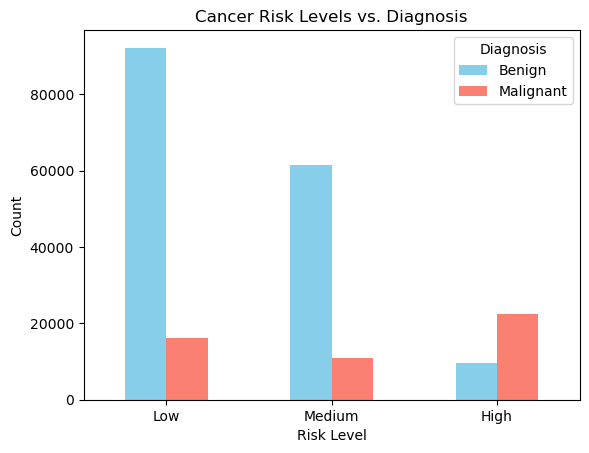

In [37]:
# Enfore this to be a categorical column so order displayed in plot is correct
df['Thyroid_Cancer_Risk'] = pd.Categorical(df['Thyroid_Cancer_Risk'], categories=['Low', 'Medium', 'High'], ordered=True)

counts = df.groupby(['Thyroid_Cancer_Risk', 'Diagnosis'], observed=False)["Diagnosis"].count().unstack()
counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.title('Cancer Risk Levels vs. Diagnosis')
plt.xticks(rotation=0)
plt.legend(title='Diagnosis')

The dataset includes the following categorical data columns: "Gender", "Country", "Ethnicity", "Family_History", "Radiation_Exposure", "Iodine_Deficiency", "Smoking", "Obesity", "Diabetes", "Thyroid_Cancer_Risk", "Diagnosis". In order to analyse these and later use these in a neural network, we must encode these values. For simplicity sake, and keeping the dimensionality of the dataset low, these columns are all encoded using Sci-kit Learn's Label encoder. The process and the output can be seen below:

In [38]:
from sklearn.preprocessing import LabelEncoder

#Encode data
le = LabelEncoder()
encoded_df = df.copy()

columns = ["Gender", "Country", "Ethnicity", "Family_History", "Radiation_Exposure", "Iodine_Deficiency", "Smoking", "Obesity", "Diabetes", "Thyroid_Cancer_Risk", "Diagnosis"]

for column in columns:
  encoded_df[column] = le.fit_transform(df[column])

encoded_df

,Age,Gender,Country,Ethnicity,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,TSH_Level,T3_Level,T4_Level,Nodule_Size,Thyroid_Cancer_Risk,Diagnosis
0,66,1,6,2,0,1,0,0,0,0,9.37,1.67,6.16,1.08,1,0
1,29,1,2,3,0,1,0,0,0,0,1.83,1.73,10.54,4.05,1,0
2,86,1,5,2,0,0,0,0,0,0,6.26,2.59,10.57,4.61,1,0
3,75,0,3,1,0,0,0,0,0,0,4.10,2.62,11.04,2.46,2,0
4,35,0,2,0,1,1,0,0,0,0,9.10,2.11,10.71,2.11,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212686,58,0,3,1,0,0,0,0,1,0,2.00,0.64,11.92,1.48,1,0
212687,89,1,4,4,0,0,0,0,1,0,9.77,3.25,7.30,4.46,2,0
212688,72,0,5,3,0,0,0,0,0,1,7.72,2.44,8.71,2.36,2,0
212689,85,0,0,4,0,0,0,0,0,1,5.62,2.53,9.62,1.54,2,0


                Feature    Chi2 Stat       P-value
14  Thyroid_Cancer_Risk  9608.660813  0.000000e+00
4        Family_History  2956.299276  0.000000e+00
3             Ethnicity  1990.222073  0.000000e+00
6     Iodine_Deficiency  1565.973944  0.000000e+00
5    Radiation_Exposure  1433.738538  0.000000e+00
2               Country   161.814823  4.540931e-37
10            TSH_Level     2.458406  1.168974e-01
9              Diabetes     1.761771  1.844038e-01
13          Nodule_Size     1.252263  2.631206e-01
11             T3_Level     0.454651  5.001344e-01
1                Gender     0.264209  6.072430e-01
8               Obesity     0.226356  6.342394e-01
12             T4_Level     0.178488  6.726762e-01
7               Smoking     0.126405  7.221894e-01
0                   Age     0.025448  8.732552e-01


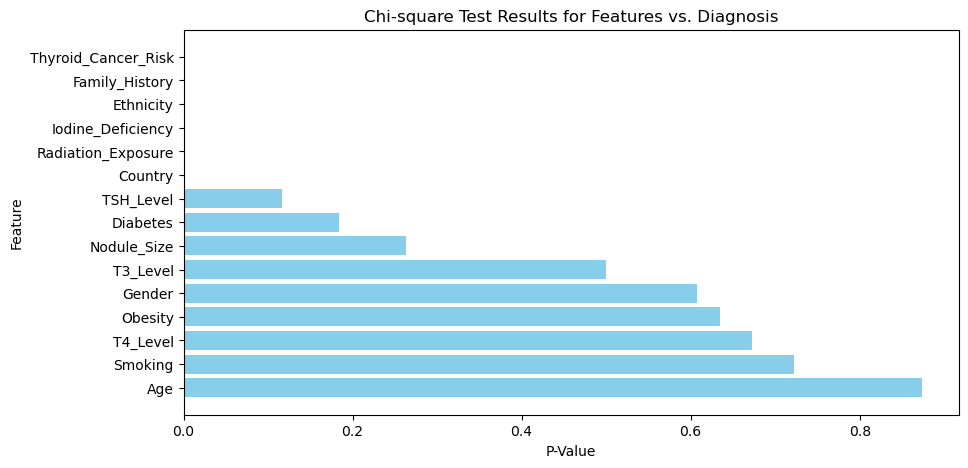

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2

# Code from [https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html]
X = encoded_df.drop(columns=['Diagnosis'])
y = encoded_df['Diagnosis']
chi2_stats, p_values = chi2(X, y)
# End of source [https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html]

chi2_df = pd.DataFrame({'Feature': X.columns, 'Chi2 Stat': chi2_stats, 'P-value': p_values})
chi2_df = chi2_df.sort_values(by='Chi2 Stat', ascending=False)

print(chi2_df)

# Plot results
plt.figure(figsize=(10, 5))
plt.barh(chi2_df['Feature'], chi2_df['P-value'], color='skyblue')
plt.xlabel("P-Value")
plt.ylabel("Feature")
plt.title("Chi-square Test Results for Features vs. Diagnosis")
plt.gca().invert_yaxis()
plt.show()


As you can see, the factors with the highest correlations to diagnosis type (in order) are:
- Thyroid Cancer Risk
- Family History
- Ethnicity
- Idodine-Deficiency
- Radiation_Exposure
- Country

We can argue, with a certain level of confidence, that factors such as nodule_size, gender, obesity and age have no statistical relevance on whether a thyroid cancer diagnosis is benign or malignant.

### <a id='toc1_3_3_'></a>[Data Preprocessing](#toc0_)
Next, we split the data in to features and labels, normalise the features, and then split both the features and labels into training and testing sets, stratifying the split over the label classes

In [40]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Normalize the DataFrame
normalised_df = pd.DataFrame(scaler.fit_transform(encoded_df), columns=encoded_df.columns)

features = encoded_df.drop(columns=["Diagnosis"])
normalised_features = scaler.fit_transform(features)
labels = encoded_df["Diagnosis"].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(normalised_features, labels, stratify=labels, test_size=0.2)


x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

### <a id='toc1_3_4_'></a>[Training](#toc0_)


Here, we define a class to build our models from. The class is used to define a neural network and takes name, layers, criterion, optimizer_class and optimizer_kwargs as paramaters. The class provides methods for training the model based on input and output data, as well as evaluation on test data

In [41]:
from sklearn.metrics import confusion_matrix

#Code from [https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html]
class NeuralNetwork(torch.nn.Module):
  def __init__(self, name, layers, criterion, optimizer_class, optimizer_kwargs):
    super().__init__()
    self.name = name
    self.flatten = torch.nn.Flatten()
    self.connected_layers = layers
    self.criterion = criterion
    self.optimizer = optimizer_class(self.parameters(), **optimizer_kwargs)
    self.losses = []
    self.accuracies = []

  def forward(self, x):
    x = self.flatten(x)
    output = self.connected_layers(x)
    return output
  
# End of source [https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html]


# Start of source [https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html]
  def backward(self, y_pred, y_train):
    self.optimizer.zero_grad()
    loss = self.criterion(y_pred.squeeze(), y_train)
    self.losses.append(loss.item())
    # Start of source [https://github.com/Prixis10/Breast-Cancer-Detection-Using-Pytorch/blob/main/breast_cancer_detection.ipynb]
    accuracy = (y_pred.squeeze().round() == y_train).float().mean()
    self.accuracies.append(accuracy.item())
    # End of source [https://github.com/Prixis10/Breast-Cancer-Detection-Using-Pytorch/blob/main/breast_cancer_detection.ipynb]
    loss.backward()
    self.optimizer.step()
    return loss

  def train(self, x, y, epochs):
    print(f"Training {self.name}")
    for epoch in range(0, epochs):
      y_pred = self.forward(x)
      loss = self.backward(y_pred, y)
      if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"epoch = {epoch}, loss = {loss}")
    print(f"Done training {self.name}\n")
# End of source [https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html]

  def test(self, x, y):
    y_pred = self.forward(x)
    predicted_labels = (y_pred >= 0.5).float()
    self.test_accuracy = (predicted_labels.squeeze() == y).float().mean()
    self.test_cm = confusion_matrix(y_test, predicted_labels)

Next, we define 3 neural networks for binary classification. Each one has a slightly different configuration of hyperparameters to see how these effect the performance of the network.
1. The first network uses 1 hidden layer with a signmoid function to output the probability of a class. It uses the Adam optimiser with a learning rate of 0.01 and weight decay of 0.001
2. The second network consists of 2 hidden layers and uses the ReLU activation function and the sigmoid function. This is to see the effect of changing the hidden layer structure when compared with the first model. For consistency, it uses the same optimiser as model 1
3. The third network is identical to model 2 but adjusts the learning rate from 0.01 to 0.001 to evaluate how this affects model performance


In [42]:
INPUT_SIZE = x_train_tensor.shape[1]

networks = [
    NeuralNetwork(
        name="Model 1",
        layers=torch.nn.Sequential(
            torch.nn.Linear(INPUT_SIZE, 1),
            torch.nn.Sigmoid()
        ),
        criterion = torch.nn.BCELoss(),
        optimizer_class = torch.optim.Adam,
        optimizer_kwargs = {"lr": 0.01, "weight_decay":0.001}
      ),
    NeuralNetwork(
        name="Model 2",
        layers=torch.nn.Sequential(
            torch.nn.Linear(INPUT_SIZE, 5),
            torch.nn.ReLU(),
            torch.nn.Linear(5, 1),
            torch.nn.Sigmoid()
        ),
        criterion = torch.nn.BCELoss(),
        optimizer_class = torch.optim.Adam,
        optimizer_kwargs = {"lr": 0.01, "weight_decay":0.001}
      ),
    NeuralNetwork(
        name="Model 3",
        layers=torch.nn.Sequential(
            torch.nn.Linear(INPUT_SIZE, 5),
            torch.nn.ReLU(),
            torch.nn.Linear(5, 1),
            torch.nn.Sigmoid()
        ),
        criterion = torch.nn.BCELoss(),
        optimizer_class = torch.optim.Adam,
        optimizer_kwargs = {"lr": 0.001, "weight_decay":0.001}
      ),
    NeuralNetwork(
        name="Model 4",
        layers=torch.nn.Sequential(
            torch.nn.Linear(INPUT_SIZE, 5),
            torch.nn.ReLU(),
            torch.nn.Linear(5, 1),
            torch.nn.Sigmoid()
        ),
        criterion = torch.nn.BCELoss(),
        optimizer_class = torch.optim.Adamax,
        optimizer_kwargs = {"lr": 0.01, "weight_decay":0.001}
      ),
    ]

In [43]:
# Train networks and collect training data
for network in networks:
    network.train(x_train_tensor, y_train_tensor, 500)

Training Model 1
epoch = 0, loss = 0.8605973720550537
epoch = 10, loss = 0.6596623659133911
epoch = 20, loss = 0.5729052424430847
epoch = 30, loss = 0.5505322813987732
epoch = 40, loss = 0.5439426898956299
epoch = 50, loss = 0.5370354056358337
epoch = 60, loss = 0.5299444794654846
epoch = 70, loss = 0.5241744518280029
epoch = 80, loss = 0.5194891691207886
epoch = 90, loss = 0.5154256224632263
epoch = 100, loss = 0.5119074583053589
epoch = 110, loss = 0.508906900882721
epoch = 120, loss = 0.5063421130180359
epoch = 130, loss = 0.5041384100914001
epoch = 140, loss = 0.502234160900116
epoch = 150, loss = 0.5005748867988586
epoch = 160, loss = 0.4991147518157959
epoch = 170, loss = 0.4978164732456207
epoch = 180, loss = 0.4966495931148529
epoch = 190, loss = 0.4955899715423584
epoch = 200, loss = 0.49461859464645386
epoch = 210, loss = 0.49372047185897827
epoch = 220, loss = 0.49288424849510193
epoch = 230, loss = 0.49210110306739807
epoch = 240, loss = 0.49136438965797424
epoch = 250, los

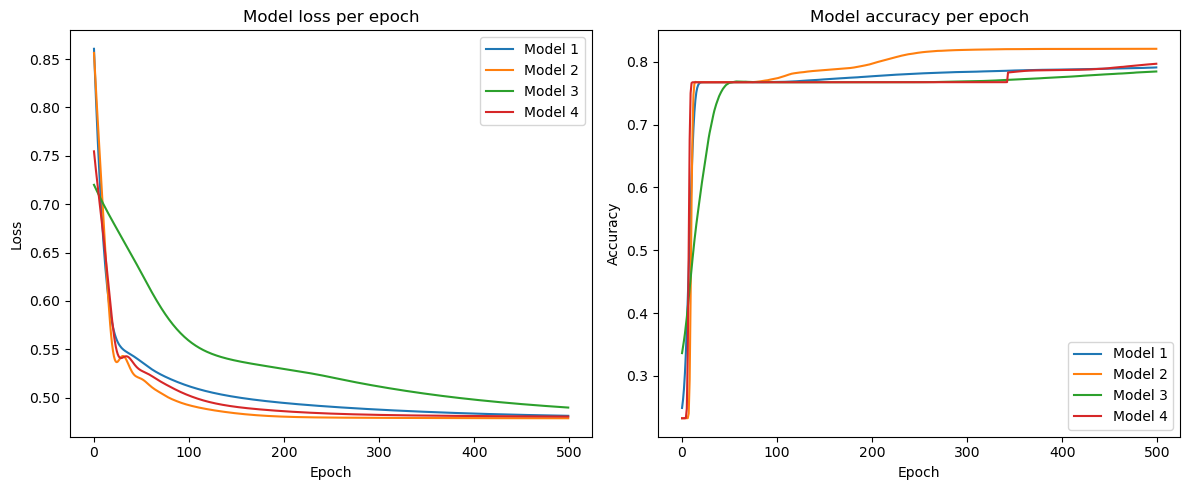

In [44]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot loss and accuracy curves
for network in networks:
    axes[0].plot(network.losses, label=network.name)
    axes[1].plot(network.accuracies, label=network.name)

axes[0].set_title("Model loss per epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].set_title("Model accuracy per epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()

Finally, we predict our labels on the test set, and visualise them in a confusion matrix.

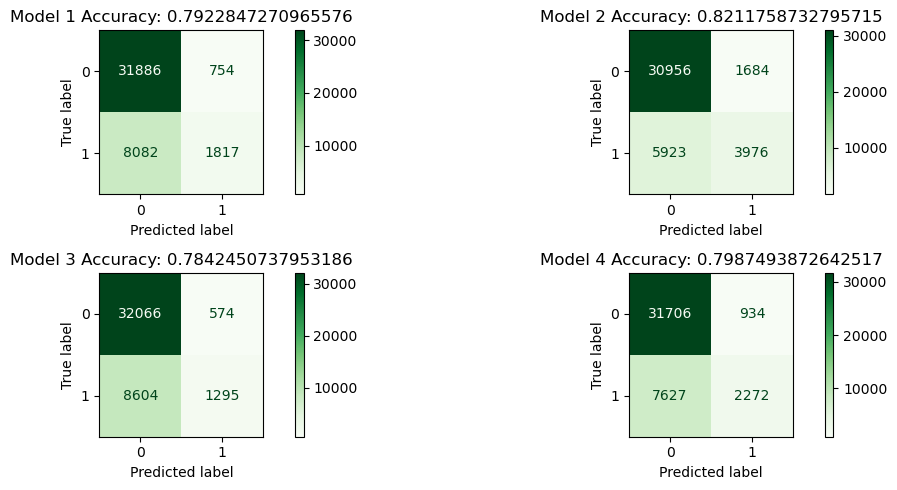

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 5))
axes = axes.flatten()

with torch.no_grad():
    for i, network in enumerate(networks):
        network.test(x_test_tensor, y_test_tensor)
        disp_1 = ConfusionMatrixDisplay(confusion_matrix=network.test_cm)
        disp_1.plot(ax=axes[i], cmap="Greens")
        axes[i].set_title(f"{network.name} Accuracy: {network.test_accuracy.item()}")

plt.tight_layout()
plt.show()

### <a id='toc1_3_5_'></a>[Alternative Models](#toc0_)

In [(https://dataknowsall.com/blog/classification.html)], the author uses a LogsticRegression and a RandomForestClassifier from sci-kit learn for their binary classification task. For sake of comparison, we will now implement these models as well to compare them with our neural networks.

In [46]:
# Start of source [https://dataknowsall.com/blog/classification.html]
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

models = {
        'LogReg' : LogisticRegression(random_state=42, class_weight='balanced', max_iter=500),
        'RandomForest' : RandomForestClassifier(class_weight='balanced', random_state=42)
        }

for name, model, in models.items():
    model.fit(x_train, y_train)
    print(f"{name}: {model.score(x_test, y_test)}")
# End of source [https://dataknowsall.com/blog/classification.html]

LogReg: 0.6798702367239474
RandomForest: 0.8263946025999671


## <a id='toc1_4_'></a>[Discussion](#toc0_)

## <a id='toc1_5_'></a>[ References](#toc0_)
1. 
2. 
3. 
4. 
5. 
6. 
7. 
8. 
9. 
10. 